# CO395 Coursework 2

## Question 1

In [1]:
import numpy as np
import pickle


def xavier_init(size, gain=1.0):
    """
    Xavier initialization of network weights.
    """
    low = -gain * np.sqrt(6.0 / np.sum(size))
    high = gain * np.sqrt(6.0 / np.sum(size))
    return np.random.uniform(low=low, high=high, size=size)

In [2]:
class Layer:
    """
    Abstract layer class.
    """

    def __init__(self, *args, **kwargs):
        raise NotImplementedError()

    def forward(self, *args, **kwargs):
        raise NotImplementedError()

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

    def backward(self, *args, **kwargs):
        raise NotImplementedError()

    def update_params(self, *args, **kwargs):
        pass

In [3]:
class MSELossLayer(Layer):
    """
    MSELossLayer: Computes mean-squared error between y_pred and y_target.
    """

    def __init__(self):
        self._cache_current = None

    @staticmethod
    def _mse(y_pred, y_target):
        return np.mean((y_pred - y_target) ** 2)

    @staticmethod
    def _mse_grad(y_pred, y_target):
        return 2 * (y_pred - y_target) / len(y_pred)

    def forward(self, y_pred, y_target):
        self._cache_current = y_pred, y_target
        return self._mse(y_pred, y_target)

    def backward(self):
        return self._mse_grad(*self._cache_current)

In [4]:
class CrossEntropyLossLayer(Layer):
    """
    CrossEntropyLossLayer: Computes the softmax followed by the negative log-
    likelihood loss.
    """

    def __init__(self):
        self._cache_current = None

    @staticmethod
    def softmax(x):
        numer = np.exp(x - x.max(axis=1, keepdims=True))
        denom = numer.sum(axis=1, keepdims=True)
        return numer / denom

    def forward(self, inputs, y_target):
        assert len(inputs) == len(y_target)
        n_obs = len(y_target)
        probs = self.softmax(inputs)
        self._cache_current = y_target, probs

        out = -1 / n_obs * np.sum(y_target * np.log(probs))
        return out

    def backward(self):
        y_target, probs = self._cache_current
        n_obs = len(y_target)
        return -1 / n_obs * (y_target - probs)

In [5]:
class SigmoidLayer(Layer):
    """
    SigmoidLayer: Applies sigmoid function elementwise.
    """

    def __init__(self):
        self._cache_current = None

    def forward(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        out = 1. / (1 + np.exp(-x))
        self._cache_current = out
        return out
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def backward(self, grad_z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        return self._cache_current * (1. - self._cache_current) * grad_z

        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################


class ReluLayer(Layer):
    """
    ReluLayer: Applies Relu function elementwise.
    """

    def __init__(self):
        self._cache_current = None

    def forward(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        out = np.maximum(x, 0)
        self._cache_currentcache = x
        return out

        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def backward(self, grad_z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        dX = grad_z.copy()
        dX[self._cache_currentcache <= 0] = 0
        return dX
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

In [6]:
class LinearLayer(Layer):
    """
    LinearLayer: Performs affine transformation of input.
    """

    def __init__(self, n_in, n_out):
        """Constructor.

        Arguments:
            n_in {int} -- Number (or dimension) of inputs.
            n_out {int} -- Number (or dimension) of outputs.
        """
        self.n_in = n_in
        self.n_out = n_out

        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        self._W = None
        self._b = None
        self._W = xavier_init((n_in,n_out))
        self._b = xavier_init((1,n_out))
        self._cache_current = None
        self._grad_W_current = None
        self._grad_b_current = None

        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def forward(self, x):
        """
        Performs forward pass through the layer (i.e. returns Wx + b).

        Logs information needed to compute gradient at a later stage in
        `_cache_current`.

        Arguments:
            x {np.ndarray} -- Input array of shape (batch_size, n_in).

        Returns:
            {np.ndarray} -- Output array of shape (batch_size, n_out)
        """
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        out = x @ self._W + self._b
        self._cache_current = (self._W,x)
        return out
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def backward(self, grad_z):
        """
        Given `grad_z`, the gradient of some scalar (e.g. loss) with respect to
        the output of this layer, performs back pass through the layer (i.e.
        computes gradients of loss with respect to parameters of layer and
        inputs of layer).

        Arguments:
            grad_z {np.ndarray} -- Gradient array of shape (batch_size, n_out).

        Returns:
            {np.ndarray} -- Array containing gradient with repect to layer
                input, of shape (batch_size, n_in).
        """
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        W, h = self._cache_current
        self._grad_W_current = h.T @ grad_z
        self._grad_b_current = np.sum(grad_z, axis=0)
        return grad_z @ W.T

        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def update_params(self, learning_rate):
        """
        Performs one step of gradient descent with given learning rate on the
        layer's parameters using currently stored gradients.

        Arguments:
            learning_rate {float} -- Learning rate of update step.
        """
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        self._W -= learning_rate * self._grad_W_current
        self._b -= learning_rate * self._grad_b_current
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

In [7]:
class MultiLayerNetwork(object):
    """
    MultiLayerNetwork: A network consisting of stacked linear layers and
    activation functions.
    """

    def __init__(self, input_dim, neurons, activations):
        """Constructor.

        Arguments:
            input_dim {int} -- Dimension of input (excluding batch dimension).
            neurons {list} -- Number of neurons in each layer represented as a
                list (the length of the list determines the number of layers).
            activations {list} -- List of the activation function to use for
                each layer.
        """
        self.input_dim = input_dim
        self.neurons = neurons
        self.activations = activations

        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        self._layers = None
        layers = []
        n_layers = len(neurons)
        for i in range(n_layers):
            if i == 0:
                layer = LinearLayer(input_dim,neurons[0])
            else:
                layer = LinearLayer(neurons[i-1],neurons[i])
            if activations[i] == 'sigmoid':
                act = SigmoidLayer()
            elif activations[i] == 'relu':
                act = ReluLayer()
            else:
                act = 'identity'
            layers.append((layer,act))
        self._layers = layers
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def forward(self, x):
        """
        Performs forward pass through the network.

        Arguments:
            x {np.ndarray} -- Input array of shape (batch_size, input_dim).

        Returns:
            {np.ndarray} -- Output array of shape (batch_size,
                #_neurons_in_final_layer)
        """
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        for (layer_i,act_i) in self._layers:
            x = layer_i.forward(x)
            if act_i == 'identity':
                x = x
            else:
                x = act_i.forward(x)
        return x
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def __call__(self, x):
        return self.forward(x)

    def backward(self, grad_z):
        """
        Performs backward pass through the network.

        Arguments:
            grad_z {np.ndarray} -- Gradient array of shape (1,
                #_neurons_in_final_layer).

        Returns:
            {np.ndarray} -- Array containing gradient with repect to layer
                input, of shape (batch_size, input_dim).
        """
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        for (layer_i,act_i) in reversed(self._layers):
            if act_i == 'identity':
                grad_z = grad_z
            else:
                grad_z = act_i.backward(grad_z)
            grad_z = layer_i.backward(grad_z)
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def update_params(self, learning_rate):
        """
        Performs one step of gradient descent with given learning rate on the
        parameters of all layers using currently stored gradients.

        Arguments:
            learning_rate {float} -- Learning rate of update step.
        """
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        for (layer_i,act_i) in self._layers:
            layer_i.update_params(learning_rate)
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################


def save_network(network, fpath):
    """
    Utility function to pickle `network` at file path `fpath`.
    """
    with open(fpath, "wb") as f:
        pickle.dump(network, f)


def load_network(fpath):
    """
    Utility function to load network found at file path `fpath`.
    """
    with open(fpath, "rb") as f:
        network = pickle.load(f)
    return network

In [8]:
class Trainer(object):
    """
    Trainer: Object that manages the training of a neural network.
    """

    def __init__(
        self,
        network,
        batch_size,
        nb_epoch,
        learning_rate,
        loss_fun,
        shuffle_flag,
    ):
        """Constructor.

        Arguments:
            network {MultiLayerNetwork} -- MultiLayerNetwork to be trained.
            batch_size {int} -- Training batch size.
            nb_epoch {int} -- Number of training epochs.
            learning_rate {float} -- SGD learning rate to be used in training.
            loss_fun {str} -- Loss function to be used. Possible values: mse,
                bce.
            shuffle_flag {bool} -- If True, training data is shuffled before
                training.
        """
        self.network = network
        self.batch_size = batch_size
        self.nb_epoch = nb_epoch
        self.learning_rate = learning_rate
        self.loss_fun = loss_fun
        self.shuffle_flag = shuffle_flag

        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        self._loss_layer = None
        if loss_fun == 'mse':
            self._loss_layer  = MSELossLayer()
        elif loss_fun == 'cross_entropy':
            self._loss_layer = CrossEntropyLossLayer()
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    @staticmethod
    def shuffle(input_dataset, target_dataset):
        """
        Returns shuffled versions of the inputs.

        Arguments:
            - input_dataset {np.ndarray} -- Array of input features, of shape
                (#_data_points, n_features).
            - target_dataset {np.ndarray} -- Array of corresponding targets, of
                shape (#_data_points, ).

        Returns: 2-tuple of np.ndarray: (shuffled inputs, shuffled_targets).
        """
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        rand_indx = np.arange(len(input_dataset))
        np.random.shuffle(rand_indx)
        input_dataset = input_dataset[rand_indx]
        target_dataset = target_dataset[rand_indx]
        return input_dataset,target_dataset
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def train(self, input_dataset, target_dataset):
        """
        Main training loop. Performs the following steps `nb_epoch` times:
            - Shuffles the input data (if `shuffle` is True)
            - Splits the dataset into batches of size `batch_size`.
            - For each batch:
                - Performs forward pass through the network given the current
                batch of inputs.
                - Computes loss.
                - Performs backward pass to compute gradients of loss with
                respect to parameters of network.
                - Performs one step of gradient descent on the network
                parameters.

        Arguments:
            - input_dataset {np.ndarray} -- Array of input features, of shape
                (#_training_data_points, n_features).
            - target_dataset {np.ndarray} -- Array of corresponding targets, of
                shape (#_training_data_points, ).
        """
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        for i in range(self.nb_epoch):
            train_loss = []
            n_train_batches = input_dataset.shape[0] // self.batch_size
            if self.shuffle_flag == True:
                input_dataset, target_dataset = self.shuffle(input_dataset,target_dataset)
            for j in range(n_train_batches):
                x_train = input_dataset[j*self.batch_size:(j+1)*self.batch_size]
                y = target_dataset[j*self.batch_size:(j+1)*self.batch_size]
                y_out = self.network(x_train)
                if self.loss_fun == 'mse':
                    loss = self._loss_layer.forward(y_out,y)
                elif self.loss_fun == 'cross_entropy':    
                    loss = self._loss_layer.forward(y_out,y)
                train_loss.append(loss)
                grad_z = self._loss_layer.backward()
                self.network.backward(grad_z)
                self.network.update_params(self.learning_rate)
            if i%10 ==0:
                print('epoch',i, 'loss is',loss)
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def eval_loss(self, input_dataset, target_dataset):
        """
        Function that evaluate the loss function for given data.

        Arguments:
            - input_dataset {np.ndarray} -- Array of input features, of shape
                (#_evaluation_data_points, n_features).
            - target_dataset {np.ndarray} -- Array of corresponding targets, of
                shape (#_evaluation_data_points, ).
        """
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        y_out= self.network(input_dataset)
        if self.loss_fun == 'mse':
            loss = self._loss_layer.forward(y_out,target_dataset)
        elif self.loss_fun == 'cross_entropy':    
            y_pred = CrossEntropyLossLayer.softmax(y_out)
            loss = self._loss_layer.forward(y_pred,target_dataset)        
        return loss
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

In [9]:
class Preprocessor(object):
    """
    Preprocessor: Object used to apply "preprocessing" operation to datasets.
    The object can also be used to revert the changes.
    """

    def __init__(self, data):
        """
        Initializes the Preprocessor according to the provided dataset.
        (Does not modify the dataset.)

        Arguments:
            - data {np.ndarray} dataset used to determined the parameters for
            the normalization.
        """
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        self.x_max = np.max(data,axis=0)
        self.x_min = np.min(data,axis=0)
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def apply(self, data):
        """
        Apply the pre-processing operations to the provided dataset.

        Arguments:
            - data {np.ndarray} dataset to be normalized.

        Returns:
            {np.ndarray} normalized dataset.
        """
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        return (data-self.x_min) / (self.x_max -self.x_min)
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def revert(self, data):
        """
        Revert the pre-processing operations to retreive the original dataset.

        Arguments:
            - data {np.ndarray} dataset for which to revert normalization.

        Returns:
            {np.ndarray} reverted dataset.
        """
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        return data *(self.x_max -self.x_min) + self.x_min
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

In [10]:
def example_main():
    input_dim = 4
    neurons = [16,3]
    activations = ["relu","identity"]
    net = MultiLayerNetwork(input_dim, neurons, activations)

    dat = np.loadtxt("iris.dat")
    np.random.shuffle(dat)

    x = dat[:, :4]
    y = dat[:, 4:]

    split_idx = int(0.8 * len(x))

    x_train = x[:split_idx]
    y_train = y[:split_idx]
    x_val = x[split_idx:]
    y_val = y[split_idx:]

    prep_input = Preprocessor(x_train)

    x_train_pre = prep_input.apply(x_train)
    x_val_pre = prep_input.apply(x_val)

    trainer = Trainer(
        network=net,
        batch_size=30,
        nb_epoch=1000,
        learning_rate=0.01,
        loss_fun="cross_entropy",
        shuffle_flag=True,
    )

    trainer.train(x_train_pre, y_train)
    print("Train loss = ", trainer.eval_loss(x_train_pre, y_train))
    print("Validation loss = ", trainer.eval_loss(x_val_pre, y_val))

    preds = net(x_val_pre).argmax(axis=1).squeeze()
    targets = y_val.argmax(axis=1).squeeze()
    accuracy = (preds == targets).mean()
    print("Validation accuracy: {}".format(accuracy))

In [11]:
example_main()

epoch 0 loss is 1.4184716697065125
epoch 10 loss is 1.0496075975132926
epoch 20 loss is 1.093633817086784
epoch 30 loss is 1.135469157179743
epoch 40 loss is 1.0295397314602706
epoch 50 loss is 1.0153000040168498
epoch 60 loss is 0.9916271853558155
epoch 70 loss is 0.9724362183747963
epoch 80 loss is 0.9185364896524816
epoch 90 loss is 0.865643822067978
epoch 100 loss is 0.8475223628212325
epoch 110 loss is 0.8332224325415594
epoch 120 loss is 0.7995136788797035
epoch 130 loss is 0.7135888725502441
epoch 140 loss is 0.6853756677954048
epoch 150 loss is 0.6417746627463722
epoch 160 loss is 0.6759557561239222
epoch 170 loss is 0.6617877429889505
epoch 180 loss is 0.6220059304103349
epoch 190 loss is 0.5800543149151701
epoch 200 loss is 0.5140245877568453
epoch 210 loss is 0.47370419601248454
epoch 220 loss is 0.5380350326355875
epoch 230 loss is 0.5542031555133592
epoch 240 loss is 0.537263777126755
epoch 250 loss is 0.5244007209697055
epoch 260 loss is 0.4586693588983255
epoch 270 loss 

## Question 2

### Simulator

In [12]:
from __future__ import division
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import numpy as np


class RobotArm(object):
    def __init__(self):
        self.dh_a=      [     0,      0,     340, 0,     0,    0]
        self.dh_alpha=  [     0,-np.pi/2,    0,     np.pi/2,   -np.pi/2,    np.pi/2]
        self.dh_d=      [ 290,      0,     0,     302,     0, 72] 
        self.dh_offset= [     0,-np.pi/2,    0,     0,         0,    0]
        self.radius=[90, 90, 90, 80, 70, 70, 20]

        self.zone1  = [(-800,-800,-500), (-800, 800,-500), ( 800,-800,-500), (-800,-800, 100)] # ground
        self.zone2  = [(-800,-250, 100), (-800, 250, 100), (-150,-250, 100), (-800,-250, 600)] # front of the robot
        self.zone3a = [(-350, 250, 100), (-350, 450, 100), (-150, 250, 100), (-350, 250, 300)] # container 1
        self.zone3b = [(-350,-450, 100), (-350,-250, 100), (-150,-450, 100), (-350,-450, 300)] # container 2
        
        
    def get_dh_mat(self, a, alpha, d, theta):
        mat = np.array([[ np.cos(theta),            -np.sin(theta),             0,           a ],
                        [ np.sin(theta)*np.cos(alpha),  np.cos(theta)*np.cos(alpha), -np.sin(alpha), -d*np.sin(alpha)],
                        [ np.sin(theta)*np.sin(alpha),  np.cos(theta)*np.sin(alpha),  np.cos(alpha),  d*np.cos(alpha)],
                        [0, 0, 0, 1]])

        return mat

    def model(self, angular_positions):
        transforms = np.zeros((4,4,len(self.dh_a)+1))
        T=np.zeros((4,4))
        np.fill_diagonal(T, 1)
        transforms[:,:,0] = T 
        for i, angle in enumerate(angular_positions):
            submat = self.get_dh_mat(self.dh_a[i],self.dh_alpha[i],self.dh_d[i],  self.dh_offset[i] + angle)
            T=np.matmul(T,submat)
            transforms[:,:,i+1] = T 
        return transforms

    def forward_model(self, angular_positions):
        conf=self.model(angular_positions)
        return np.matmul(conf[:,:,-1],np.array([0,0,0,1]))[np.r_[0:3]]
    
    def config_ax(self, ax):
        ax.set_xlim3d(-1000,1000)
        ax.set_ylim3d(-1000,1000)
        ax.set_zlim3d(-1000,1000)
        ax.set_aspect('equal', 'box')
        

    def create_ax(self,fig):
        ax = Axes3D(fig)
        self.config_ax(ax)
        return ax

    def plot_conf(self, ax, angular_positions):
        conf=self.model(angular_positions)
        
        cube_definition = [
            (-100,-100,0), (-100,100,0), (100,-100,0), (-100, -100, 100)
            ]
        self.plot_cube(ax,cube_definition)


        pos = conf[0:3,-1,:]
        
        #self.plot_sphere(ax, [0,0,0])

        for i in range(pos.shape[1]):
            if i==pos.shape[1]-1:
                x=np.matmul( conf[:,:,i], np.array([200,0,0,1]))[np.r_[0:3]]
                y=np.matmul( conf[:,:,i], np.array([0,200,0,1]))[np.r_[0:3]]
                z=np.matmul( conf[:,:,i], np.array([0,0,200,1]))[np.r_[0:3]]
                
                ax.plot([pos[0,i],x[0]],[pos[1,i],x[1]],[pos[2,i],x[2]],'r')
                ax.plot([pos[0,i],y[0]],[pos[1,i],y[1]],[pos[2,i],y[2]],'g')
                ax.plot([pos[0,i],z[0]],[pos[1,i],z[1]],[pos[2,i],z[2]],'b')


            if i>0:
                self.plot_sphere(ax, pos[:,i],1.2*self.radius[i]/2)
                self.plot_cylinder(ax, pos[:,i-1], pos[:,i],self.radius[i]/2)
        
        self.plot_cube(ax,self.zone1,[0.3,0.3,0.3,0.35])
        self.plot_cube(ax,self.zone2,[0.3,0.3,0.8,0.35])
        self.plot_cube(ax,self.zone3a,[0.3,0.8,0.3,0.35])
        self.plot_cube(ax,self.zone3b,[0.3,0.8,0.3,0.35])

    def plot(self, angular_positions):
        fig = plt.figure()
        ax=self.create_ax(fig)
        self.plot_conf(ax,angular_positions)
        plt.show()
        
    def animate(self, angle_init,angle_end, ax = None, predicted_pos=None):

        
        T=100;
        if (ax==None):
            fig = plt.figure()
            ax = self.create_ax(fig)
        for t in range(T):
            ax.clear()
            self.config_ax(ax)
            self.plot_conf(ax,angle_init + t/T * (angle_end-angle_init))
            if(predicted_pos is not None):


                ax.scatter( predicted_pos[0],predicted_pos[1], predicted_pos[2])
            plt.pause(0.01)
        print("end")
        print("predicted:")
        print(predicted_pos)
        print("reached:")
        coor =self.forward_model(angle_end)
        print(coor)
       
        if (-800<=coor[0]<=800) and (-800<=coor[1]<=800) and (-500 <=coor[2] <=100):
            print('reached at ground')
        elif (-800<=coor[0]<=-150) and (-250<=coor[1]<=250) and (-100 <=coor[2] <=600):
            print('reached at zone1')
        elif (-350<=coor[0]<=150) and (250<=coor[1]<=450) and (100 <=coor[2] <=300):
            print('reach at zone2')
        elif (-350<=coor[0]<=-150) and (-450<=coor[1]<=-250) and (100 <=coor[2] <=300):
            print('reach at zone2')
        else:
            print('reach at unlabelled')
        return ax
    
    def plot_sphere(self, ax, c=[0, 0, 0], r = 0.05):
        
        u, v = np.mgrid[0:2*np.pi:10j, 0:np.pi:5j]
        x = c[0] + r*np.cos(u)*np.sin(v)
        y = c[1] + r*np.sin(u)*np.sin(v)
        z = c[2] + r*np.cos(v)

        ax.plot_surface(x, y, z, color="r")
        
        
    def plot_cylinder(self, ax, origin=np.array([0, 0, 0]), end=np.array([1,1,1]), R = 0.02):
        v = end - origin
        mag = np.linalg.norm(v)
        if mag==0:
            return
        v = v / mag

        not_v = np.array([1, 0, 0])
        if (v == not_v).all():
            not_v = np.array([0, 1, 0])

        n1 = np.cross(v, not_v)
        n1 /= np.linalg.norm(n1)

        n2 = np.cross(v, n1)

        t = np.linspace(0, mag, 10)
        theta = np.linspace(0, 2 * np.pi, 10)

        t, theta = np.meshgrid(t, theta)

        X, Y, Z = [origin[i] + v[i] * t + R * np.sin(theta) * n1[i] + R * np.cos(theta) * n2[i] for i in [0, 1, 2]]
        ax.plot_surface(X, Y, Z,color='orange')


    def plot_cube(self,ax,cube_definition, color=[0.8,0.7,0.3,1]):

        cube_definition_array = [
            np.array(list(item))
            for item in cube_definition
            ]

        points = []
        points += cube_definition_array
        vectors = [
            cube_definition_array[1] - cube_definition_array[0],
            cube_definition_array[2] - cube_definition_array[0],
            cube_definition_array[3] - cube_definition_array[0]
            ]

        points += [cube_definition_array[0] + vectors[0] + vectors[1]]
        points += [cube_definition_array[0] + vectors[0] + vectors[2]]
        points += [cube_definition_array[0] + vectors[1] + vectors[2]]
        points += [cube_definition_array[0] + vectors[0] + vectors[1] + vectors[2]]

        points = np.array(points)

        edges = [
            [points[0], points[3], points[5], points[1]],
            [points[1], points[5], points[7], points[4]],
            [points[4], points[2], points[6], points[7]],
            [points[2], points[6], points[3], points[0]],
            [points[0], points[2], points[4], points[1]],
            [points[3], points[6], points[7], points[5]]
            ]


        faces = Poly3DCollection(edges, linewidths=1)
        faces.set_facecolor(color)

        ax.add_collection3d(faces)
        


### Illustrate

In [13]:
area_map = {
    k: v
    for k, v in zip(range(4), ("Ground","Zone 1", "Zone 2",  "Unlabelled area"))
}


def softmax(x):
    numer = np.exp(x - x.max(axis=1, keepdims=True))
    denom = numer.sum(axis=1, keepdims=True)
    return numer / denom


def illustrate_results_ROI(network, prep, nb_pos=10):

    data = (
        (np.random.rand(nb_pos + 1, 7) * 2 - 1) * np.pi / 2
    )  # generating 10 cols to match length of dataset, but only the first 3 are used.
    data[0, :] = 0
    data[1:, :3] = prep.apply(data[1:, :3])
    results = network(data[1:, 0:3])
    robot = RobotArm()

    data[1:, 3:7] = results


    data[1:, :3] = prep.revert(data[1:, :3])

    prediction = [area_map[x] for x in np.argmax(data[1:, 3:7], axis=1)]
    angles = np.zeros((nb_pos + 1, 6))
    angles[:, 0:3] = data[:, 0:3]
    ax = None
    for i in range(nb_pos):
        ax = robot.animate(angles[i, :], angles[i + 1, :], ax, [0, 0, 0])
        print("Predicted region: {}".format(prediction[i]))


def illustrate_results_FM(network, prep, nb_pos=10):

    data = (
        (np.random.rand(nb_pos + 1, 6) * 2 - 1) * np.pi / 2
    )  # generating 10 cols to match length of dataset, but only the first 3 are used.
    data[0, :] = 0
    data = prep.apply(data)
    results = network(data[1:, 0:3])
    robot = RobotArm()

    data[1:, 3:6] = results
    data = prep.revert(data)

    prediction = data[1:, 3:6]
    angles = np.zeros((nb_pos + 1, 6))
    angles[:, 0:3] = data[:, 0:3]
    ax = None
    for i in range(nb_pos):
        ax = robot.animate(angles[i, :], angles[i + 1, :], ax, prediction[i, :])


### Main model

#### Load data

In [14]:
dataset = np.loadtxt("FM_dataset.dat")

np.random.shuffle(dataset)

prep_input = Preprocessor(dataset)
dataset2 = prep_input.apply(dataset)
split_idx = int(0.8 * len(dataset2))

x_train_pre= dataset2[:split_idx,:3]
y_train_pre = dataset2[:split_idx,3:]
x_val_pre = dataset2[split_idx:,:3]
y_val_pre = dataset2[split_idx:,3:]


#### Initial model

In [15]:
# Initial model

np.random.seed(10)
input_dim = 3
neurons = [16,3]
activations = ["relu","identity"]
net = MultiLayerNetwork(input_dim, neurons, activations)

trainer = Trainer(
    network=net,
    batch_size=8,
    nb_epoch=100,
    learning_rate=0.01,
    loss_fun="mse",
    shuffle_flag=True,
)
trainer.train(x_train_pre, y_train_pre)
print("Train loss = ", trainer.eval_loss(x_train_pre, y_train_pre))
print("Validation loss = ", trainer.eval_loss(x_val_pre, y_val_pre))

# R^2 metric
y_pred_pre = net(x_val_pre)
u =((y_val_pre - y_pred_pre) ** 2).sum()
v =((y_val_pre - y_val_pre.mean(axis=0)) ** 2).sum()
R2 = 1 - u/v

# MAE metric
mae =(np.abs(y_pred_pre-y_val_pre)).mean()
print("Validation Score MAE: {}".format(mae))
print("Validation Score R2: {}".format(R2))

epoch 0 loss is 0.01215344716514079
epoch 10 loss is 0.014960709140439848
epoch 20 loss is 0.008487008033637363
epoch 30 loss is 0.009216872540046599
epoch 40 loss is 0.0062297163681904145
epoch 50 loss is 0.008505123671523094
epoch 60 loss is 0.0063937223585779634
epoch 70 loss is 0.0037797798899261094
epoch 80 loss is 0.0036754640794252973
epoch 90 loss is 0.003574093504975654
Train loss =  0.004052136294701038
Validation loss =  0.004066663292969566
Validation Score MAE: 0.046518619143599324
Validation Score R2: 0.9054062949878802


#### Fine-tuned Model

In [16]:
# fine-tune model
def MLPregression_architecture(x_train_pre, y_train_pre,x_val_pre,y_val_pre):
    np.random.seed(10)
    input_dim = 3
    neurons = [512,128,32,3]
    activations = ["relu","relu","relu","identity"]
    net = MultiLayerNetwork(input_dim, neurons, activations)
    trainer = Trainer(
        network=net,
        batch_size=8,
        nb_epoch=100,
        learning_rate=0.01,
        loss_fun="mse",
        shuffle_flag=True,
    )

    trainer.train(x_train_pre, y_train_pre)
    print("Train loss = ", trainer.eval_loss(x_train_pre, y_train_pre))
    print("Validation loss = ", trainer.eval_loss(x_val_pre, y_val_pre))
    
    # R^2 metric
    y_pred_pre = net(x_val_pre)
    u =((y_val_pre - y_pred_pre) ** 2).sum()
    v =((y_val_pre - y_val_pre.mean(axis=0)) ** 2).sum()
    R2 = 1 - u/v

    # MAE metric
    mae =(np.abs(y_pred_pre-y_val_pre)).mean()
    print("Validation Score MAE: {}".format(mae))
    print("Validation Score R2: {}".format(R2))
    
    return net

    # save fine-tuned network
net=MLPregression_architecture(x_train_pre, y_train_pre,x_val_pre,y_val_pre)
save_network(net,'saved_network_2.pt')
    #######################################################################
    #                       ** END OF YOUR CODE **
    #######################################################################


epoch 0 loss is 0.022171586651246352
epoch 10 loss is 0.00048609269909375574
epoch 20 loss is 0.00020305189953380445
epoch 30 loss is 0.00023545368670505724
epoch 40 loss is 0.0002557820512673684
epoch 50 loss is 1.984850926953802e-05
epoch 60 loss is 3.80811544918878e-05
epoch 70 loss is 3.555376135119017e-05
epoch 80 loss is 3.0616562761062664e-05
epoch 90 loss is 3.610863438493935e-05
Train loss =  3.504440018186945e-05
Validation loss =  3.488817975415285e-05
Validation Score MAE: 0.004357689066395299
Validation Score R2: 0.9991884741995287


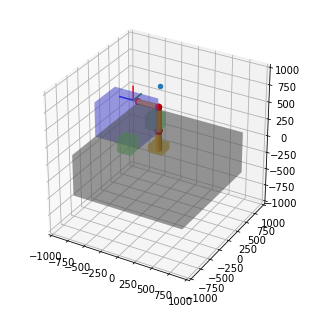

NameError: name 'time' is not defined

In [17]:
prep = Preprocessor(dataset)
illustrate_results_FM(net, prep)

#### Evaluate Architecute

In [ ]:
# haozhen
# input: 1. dataset 2. architechture of the network 3. number of folds for cv
# output: averged r2 score
import sklearn
from sklearn.model_selection import KFold
def evaluate_architecture(dataset, num_folds = 10, input_dim=3, neurons=[512,128,32,3], activations=["relu","relu","relu","identity"]):
    net = MultiLayerNetwork(input_dim, neurons, activations)
    
    r2_s = []
    mae_s = []
    
    trainer = Trainer(
        network=net,
        batch_size=8,
        nb_epoch=100,
        learning_rate=0.01,
        loss_fun="mse",
        shuffle_flag=True,
    )
    
    prep_input = Preprocessor(dataset)
    dataset_prep = prep_input.apply(dataset)
    
    kf = KFold(n_splits=num_folds)
    fold = 0
    
    X = dataset_prep[:, :3]
    y = dataset_prep[:, 3:]
    for train_index, test_index in kf.split(X):
        fold += 1
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        trainer.train(X_train, y_train)
    
        y_pred = net(X_test)
        y_true = y_test

        r2 = sklearn.metrics.r2_score(y_true, y_pred, multioutput='variance_weighted')
        mae = sklearn.metrics.mean_absolute_error(y_true, y_pred, multioutput='uniform_average')

        r2_s.append(r2)
        mae_s.append(mae)
        
        print ("fold: {} | r2: {:.3f} | mae: {:.3f}".format(fold, r2, mae))
        
    print ("r2: {} | mae: {}".format(r2_s, mae_s))
    
    return np.average(r2_s)

In [ ]:
# to know the distributino of the performance (can be 10 or 20)
for i in range(1):
    r2_s = []
    r2_s.append(evaluate_architecture(dataset))
    print(r2_s)

#### Hyperparameter Search

In [18]:
import pickle
import time
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

space = {'choice': hp.choice('num_layers',
            [ {'layers':'two', },
            {'layers':'three', 'neuron3': hp.choice('neuron3', [16,32,64,128,256,512]),
             'activation3':hp.choice('activation3',['sigmoid','relu'])},
             {'layers':'four','neuron4': hp.choice('neuron4', [16,32,64,128,256,512]),
             'activation4':hp.choice('activation5',['sigmoid','relu']),
             'neuron5': hp.choice('neuron5', [16,32,64,128,256,512]),
            'activation5':hp.choice('activation4',['sigmoid','relu'])}]),
        'neuron1': hp.choice('neuron1', [16,32,64,128,256,512]),
        'neuron2': hp.choice('neuron2', [16,32,64,128,256,512]),
        'activation1':hp.choice('activation1',['sigmoid','relu']),
        'activation2':hp.choice('activation2',['sigmoid','relu']),
        'lr':hp.uniform('lr',1e-6,1e-2),
        'batch_size':hp.choice('batch_size',[8,16,32])}
    
np.random.seed(10)
x_train_pre= dataset2[:split_idx,:3]
y_train_pre = dataset2[:split_idx,3:]
x_val_pre = dataset2[split_idx:,:3]
y_val_pre = dataset2[split_idx:,3:]

def fine_tune_2(params):
    if params['choice']['layers'] == 'two':
        neurons = [params['neuron1'],params['neuron2'],3]
        activations = [params['activation1'],params['activation2'],'identity']
    
    elif params['choice']['layers'] == 'three':
        neurons = [params['neuron1'],params['neuron2'],params['choice']['neuron3'],3]
        activations = [params['activation1'],params['activation2'],params['choice']['activation3'],'identity']

    elif params['choice']['layers'] == 'four':
        neurons = [params['neuron1'],params['neuron2'],params['choice']['neuron4'],params['choice']['neuron5'],3]
        activations = [params['activation1'],params['activation2'],params['choice']['activation4'],params['choice']['activation5'],'identity']

    net = MultiLayerNetwork(3, neurons, activations)

    trainer = Trainer(
        network=net,
        batch_size=params['batch_size'],
        nb_epoch=50,
        learning_rate=params['lr'],
        loss_fun="mse",
        shuffle_flag=True)

    trainer.train(x_train_pre, y_train_pre)
    print("Train loss = ", trainer.eval_loss(x_train_pre, y_train_pre))
    loss = trainer.eval_loss(x_val_pre, y_val_pre)
    print("Validation loss = ", loss)
    
    return {'loss': loss,'status': STATUS_OK}

trials = Trials()
best = fmin(fine_tune_2,
    space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials)

print(best)

ModuleNotFoundError: No module named 'hyperopt'

In [19]:
def predict_hidden(dataset):
    prep = Preprocessor(dataset)
    dataset=prep.apply(dataset)
    fpath = 'saved_network_2.pt'
    net = load_network(fpath)
    pred = net(dataset[:,:3])
    dataset[:,3:] =pred
    dataset = prep.revert(dataset)
    out = dataset[:,3:]
    return out

## Question 3

#### Load data

In [23]:
dat = np.loadtxt("ROI_dataset.dat")

np.random.shuffle(dat)

x = dat[:, :3]
y = dat[:, 3:]

split_idx = int(0.8 * len(x))

x_train = x[:split_idx]
y_train = y[:split_idx]
x_val = x[split_idx:]
y_val = y[split_idx:]

prep_input = Preprocessor(x_train)

x_train_pre = prep_input.apply(x_train)
x_val_pre = prep_input.apply(x_val)

#### Initial Model

In [24]:
# initial Model
np.random.seed(10)
input_dim = 3
neurons = [16,4]
activations = ["relu","identity"]
net = MultiLayerNetwork(input_dim, neurons, activations)

trainer = Trainer(
    network=net,
    batch_size=8,
    nb_epoch=100,
    learning_rate=0.01,
    loss_fun="mse",
    shuffle_flag=True,
)
trainer.train(x_train_pre, y_train)
print("Train loss = ", trainer.eval_loss(x_train_pre, y_train))
print("Validation loss = ", trainer.eval_loss(x_val_pre, y_val))

preds = net(x_val_pre).argmax(axis=1).squeeze()
targets = y_val.argmax(axis=1).squeeze()
accuracy = (preds == targets).mean()
print("Validation accuracy: {}".format(accuracy))

epoch 0 loss is 0.0984897535239868
epoch 10 loss is 0.04838659261471512
epoch 20 loss is 0.016501975003959928
epoch 30 loss is 0.021597139617231316
epoch 40 loss is 0.03426533651541116
epoch 50 loss is 0.07789367654307056
epoch 60 loss is 0.04013382973624224
epoch 70 loss is 0.07097620356066882
epoch 80 loss is 0.019579749657763122
epoch 90 loss is 0.02534157999360749
Train loss =  0.03257256746035633
Validation loss =  0.03181527343593229
Validation accuracy: 0.94176


#### Fine tuned Model

In [25]:
def MLPclassifer_architecture(x_train_pre, y_train,x_val_pre,y_val):
    input_dim = 3
    neurons = [32,32,256,128,4]
    activations = ["relu","relu","relu","relu","identity"]
    net2 = MultiLayerNetwork(input_dim, neurons, activations)
    trainer = Trainer(
        network=net2,
        batch_size=32,
        nb_epoch=200,
        learning_rate=0.073,
        loss_fun="cross_entropy",
        shuffle_flag=True,
    )
    trainer.train(x_train_pre, y_train)
    print("Train loss = ", trainer.eval_loss(x_train_pre, y_train))
    print("Validation loss = ", trainer.eval_loss(x_val_pre, y_val))

    preds = net2(x_val_pre).argmax(axis=1).squeeze()
    targets = y_val.argmax(axis=1).squeeze()
    accuracy = (preds == targets).mean()
    print("Validation accuracy: {}".format(accuracy))
    return net2

net2 = MLPclassifer_architecture(x_train_pre, y_train,x_val_pre,y_val)
save_network(net2,'saved_network_3.pt')

epoch 0 loss is 0.4918875714610639
epoch 10 loss is 0.06885058206180084
epoch 20 loss is 0.21188675571950794
epoch 30 loss is 0.05454278725654255
epoch 40 loss is 0.04933158727124837
epoch 50 loss is 0.007217705968596004
epoch 60 loss is 0.012503262947149055
epoch 70 loss is 0.005724331427735968
epoch 80 loss is 0.02935614159422583
epoch 90 loss is 0.04590040319888132
epoch 100 loss is 0.011181437350210328
epoch 110 loss is 0.06141374202822932
epoch 120 loss is 0.0008339083806949354
epoch 130 loss is 0.02366610492894655
epoch 140 loss is 0.006463952057096076
epoch 150 loss is 0.01397042154848427
epoch 160 loss is 0.006195640123597683
epoch 170 loss is 0.01776422233976415
epoch 180 loss is 0.0281124689580771
epoch 190 loss is 0.012085393240195407
Train loss =  0.7547750324724991
Validation loss =  0.7576464363020965
Validation accuracy: 0.98976


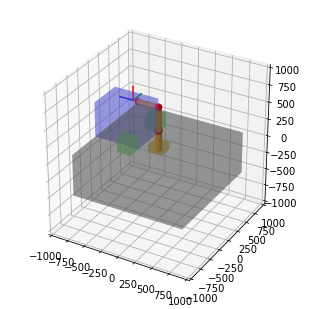

NameError: name 'time' is not defined

In [26]:
illustrate_results_ROI(net2, prep_input)

#### Evaluate Architecture

In [ ]:
# haozhen
# input: 1. dataset 2. architechture of the network 3. number of folds for cv
# output: averged f1 score
def evaluate_architecture(dataset, num_folds = 10, input_dim=3, neurons=[32,32,256,128,4], activations=["relu","relu","relu","relu","identity"]):
    import sklearn

    net = MultiLayerNetwork(input_dim, neurons, activations)
    
    accuracy_s = []
    recall_s = []
    precision_s = []
    f1_s = []
    
    trainer = Trainer(
        network=net,
        batch_size=32,
        nb_epoch=100,
        learning_rate=0.073,
        loss_fun="cross_entropy",
        shuffle_flag=True,
    )
    
    prep_input = Preprocessor(dataset)
    dataset_prep = prep_input.apply(dataset)
    
    kf = KFold(n_splits=num_folds)
    fold = 0
    
    X = dataset_prep[:, :3]
    y = dataset_prep[:, 3:]
    for train_index, test_index in kf.split(X):
        fold += 1
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

#     X_train, X_test, y_train, y_test = model_selection.train_test_split(dataset_prep[:,:3], dataset_prep[:,3:], test_size=0.25)
        trainer.train(X_train, y_train)

        y_pred = net(X_test).argmax(axis=1).squeeze()
        y_true = y_test.argmax(axis=1).squeeze()

        accuracy = sklearn.metrics.accuracy_score(y_true, y_pred, normalize=True)
        MAR = sklearn.metrics.recall_score(y_true, y_pred, average='macro')
        recall = sklearn.metrics.recall_score(y_true, y_pred, average=None)
        precision = sklearn.metrics.precision_score(y_true, y_pred, average=None)
        ma_precision = sklearn.metrics.precision_score(y_true, y_pred, average='macro')
        f1 = sklearn.metrics.f1_score(y_true, y_pred, average='macro')
        print(sklearn.metrics.confusion_matrix(y_true, y_pred))
        
        accuracy_s.append(accuracy)
        recall_s.append(MAR)
        precision_s.append(ma_precision)
        f1_s.append(f1)
        
#         print(sklearn.metrics.classification_report(y_true, y_pred))
        
        print ("fold: {} | accuracy: {} | MAR: {} | precision: {} | f1: {}\n".format(fold, accuracy, MAR, ma_precision, f1))
        
#     print ("accuracy: {} |\n recall: {} |\n precision: {} |\n f1: {} \n".format(accuracy_s, recall_s, precision_s, f1_s))
    return np.average(f1_s)

In [ ]:
# to know the distributino of the performance (can be 10 or 20)
for i in range(1):
    f1_s = []
    f1_s.append(evaluate_architecture(dat))
    print(f1_s)

#### Hyperparameter Search

In [ ]:
space = {'choice': hp.choice('num_layers',
        [ {'layers':'two', },
        {'layers':'three', 'neuron3': hp.choice('neuron3', [16,32,64,128,256]),
         'activation3':hp.choice('activation3',['sigmoid','relu'])},
         {'layers':'four','neuron4': hp.choice('neuron4', [16,32,64,128,256]),
         'activation4':hp.choice('activation5',['sigmoid','relu']),
         'neuron5': hp.choice('neuron5', [16,32,64,128,256]),
        'activation5':hp.choice('activation4',['sigmoid','relu'])}]),
    'neuron1': hp.choice('neuron1', [16,32,64,128,256]),
    'neuron2': hp.choice('neuron2', [16,32,64,128,256]),
    'activation1':hp.choice('activation1',['sigmoid','relu']),
    'activation2':hp.choice('activation2',['sigmoid','relu']),
    'lr':hp.uniform('lr',1e-4,1e-1),
    'batch_size':hp.choice('batch_size',[8,16,32])}

np.random.seed(10)
x_train_pre = prep_input.apply(x_train)
x_val_pre = prep_input.apply(x_val)

def fine_tune_3(params):
    if params['choice']['layers'] == 'two':
        neurons = [params['neuron1'],params['neuron2'],4]
        activations = [params['activation1'],params['activation2'],'identity']
    
    elif params['choice']['layers'] == 'three':
        neurons = [params['neuron1'],params['neuron2'],params['choice']['neuron3'],4]
        activations = [params['activation1'],params['activation2'],params['choice']['activation3'],'identity']

    elif params['choice']['layers'] == 'four':
        neurons = [params['neuron1'],params['neuron2'],params['choice']['neuron4'],params['choice']['neuron5'],4]
        activations = [params['activation1'],params['activation2'],params['choice']['activation4'],params['choice']['activation5'],'identity']

    net2 = MultiLayerNetwork(3, neurons, activations)

    trainer = Trainer(
        network=net2,
        batch_size=params['batch_size'],
        nb_epoch=200,
        learning_rate=params['lr'],
        loss_fun="cross_entropy",
        shuffle_flag=True)

    trainer.train(x_train_pre, y_train)
    print("Train loss = ", trainer.eval_loss(x_train_pre, y_train))
    loss = trainer.eval_loss(x_val_pre, y_val)
    print("Validation loss = ", loss)
    
    return {'loss': loss,'status': STATUS_OK}

trials = Trials()
best = fmin(fine_tune_3,
    space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials)

print(best)

In [33]:
def predict_hidden(dataset):
    prep = Preprocessor(dataset)
    dataset=prep.apply(dataset)
    x_test= dataset[:,:3]
    fpath = 'saved_network_3.pt'
    net = load_network(fpath)
    pred = net(x_test).argmax(axis=1)
    pred= np.eye(4)[pred]
    return pred

/Users/mianbaodashi/Downloads/CO395-master/CO395 CW2/nn_lib.py:70: RuntimeWarning: invalid value encountered in subtract
  numer = np.exp(x - x.max(axis=1, keepdims=True))
/Users/mianbaodashi/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/Users/mianbaodashi/Downloads/CO395-master/CO395 CW2/nn_lib.py:131: RuntimeWarning: invalid value encountered in maximum
  out = np.maximum(x, 0)
/Users/mianbaodashi/Downloads/CO395-master/CO395 CW2/nn_lib.py:144: RuntimeWarning: invalid value encountered in less_equal
  dX[self._cache_currentcache <= 0] = 0


Train loss =  nan
Validation loss =  nan
Validation accuracy: 0.08224


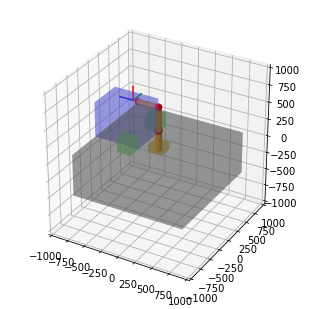

NameError: name 'time' is not defined

In [28]:
%run learn_ROI.py